In [1]:
from pathlib import Path

import pandas as pd
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport import ForcingParameter, ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization.cost_function.seasonality_cost_function import (
    GAMSeasonalityCostFunction,
    GAMSeasonalObservation,
)
from seapopym_optimization.cost_function.simple_rmse_cost_function import DayCycle, TimeSeriesObservation
from seapopym_optimization.functional_group import NoTransportFunctionalGroup, Parameter
from seapopym_optimization.genetic_algorithm import SimpleGeneticAlgorithm, SimpleGeneticAlgorithmParameters
from seapopym_optimization.genetic_algorithm.simple_logbook import generate_logbook_with_sobol_sampling
from seapopym_optimization.model_generator import NoTransportModelGenerator


In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_cmems_climato.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/data/1_products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_GAM_HOT_climato_obs_npp_opti_all_parameters_1_group_night"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-02"
TIME_END = "2009-12-27"
STABILIZATION_TIME = 5
SAVE = True

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 321kB
Dimensions:              (time: 1821, latitude: 1, longitude: 1, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-02 ... 2009-12-27
Data variables: (12/13)
    T                    (time, latitude, longitude, depth) float64 44kB 23.8...
    U                    (time, latitude, longitude, depth) float64 44kB -0.0...
    V                    (time, latitude, longitude, depth) float64 44kB -0.0...
    mnkc_epi             (time, latitude, longitude) float64 15kB 0.2862 ... ...
    mnkc_hmlmeso         (time, latitude, longitude) float64 15kB 0.8062 ... ...
    mnkc_lmeso           (time, latitude, longitude) float64 15kB 2.113 ... 2...
    ...                   ...
    mnkc_mumeso          (time, latitude, longitude) float64 15kB 0.5676 ... ...
    mnkc_umeso           (time, latitude, longitude) float64 15kB 0.4922 ... ...
    npp                  (time, latitude, longitude) float64 15kB 322.7 ... 3...
    pelagic_layer_depth  (time, latitude, longitude, depth) float64 44kB 113....
    zeu                  (time, latitude, longitude) float64 15kB 75.51 ... 7...
    zooc                 (time, latitude, longitude) float64 15kB 0.267 ... 0...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[113.25850445781492]] [[113.67641789059907]] [[113.3777614275639]] ... [[112.86924868047693]] [[113.44111669274305]] [[111.81958173122077]]]
Units,meter


<!-- ## Observed NPP -->


In [6]:
observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp.load()

<xarray.Dataset> Size: 42kB
Dimensions:          (time: 1765, latitude: 1, longitude: 1)
Coordinates:
  * latitude         (latitude) float64 8B 22.75
  * longitude        (longitude) int64 8B -158
  * time             (time) datetime64[ns] 14kB 2005-01-31 ... 2009-11-30
Data variables:
    l12              (time, latitude, longitude) float64 14kB 273.4 ... 275.3
    l12_lowess_0.05  (time, latitude, longitude) float64 14kB 274.7 ... 277.4
Attributes:
    desc:     L12 multiplied by ZEU (from CMEMS).
    type:     climatology

### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[178.58649139474625]]] [[[207.78348092804256]]] [[[265.6684200378455]]] [[[283.3215285687847]]] [[[286.8754053335449]]] [[[298.4606291423159]]] [[[316.99822292914615]]] [[[307.4117305615572]]] [[[256.3939882358341]]] [[[206.1695339111292]]] [[[184.04306987771415]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]]]
Units,milligram/meter2
Magnitude,[[[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[300.09769406058746]]] [[[339.1815897155657]]] [[[414.32509417720263]]] [[[391.31869310318103]]] [[[428.83910602723876]]] [[[427.7621889102778]]] [[[431.9547025535618]]] [[[408.89208174518643]]] [[[380.916096258274]]] [[[336.1242842926303]]] [[[282.197066227207]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]]]
Units,milligram/meter2


Remove the X first months to let the model reach the stationary state.


In [8]:
observations = observations.isel(time=slice(STABILIZATION_TIME, None))
observations

Magnitude,[[[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]] [[[189.26359852904628]]] [[[157.92219924943342]]] [[[178.58649139474625]]] [[[207.78348092804256]]] [[[265.6684200378455]]] [[[283.3215285687847]]] [[[286.8754053335449]]] [[[298.4606291423159]]] [[[316.99822292914615]]] [[[307.4117305615572]]] [[[256.3939882358341]]] [[[206.1695339111292]]] [[[184.04306987771415]]] [[[157.92219924943342]]] [[[179.50290001191829]]] [[[206.9568833881889]]] [[[265.77390000839995]]] [[[281.78101853068074]]] [[[282.22919058899055]]] [[[295.88177275463875]]] [[[313.19485204421545]]] [[[314.33474301409973]]] [[[252.30876534149797]]] [[[204.84900876732033]]]]
Units,milligram/meter2
Magnitude,[[[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]] [[[290.2018113694168]]] [[[237.0516536022709]]] [[[300.09769406058746]]] [[[339.1815897155657]]] [[[414.32509417720263]]] [[[391.31869310318103]]] [[[428.83910602723876]]] [[[427.7621889102778]]] [[[431.9547025535618]]] [[[408.89208174518643]]] [[[380.916096258274]]] [[[336.1242842926303]]] [[[282.197066227207]]] [[[237.0516536022709]]] [[[301.6376319958857]]] [[[337.83226845879244]]] [[[414.48959622350367]]] [[[389.1909678368789]]] [[[421.89365674709336]]] [[[424.06609922351373]]] [[[426.77207432265106]]] [[[418.1004648101298]]] [[[374.8468152741032]]] [[[333.9713931237319]]]]
Units,milligram/meter2


Select the kind of observation you want to use.


In [9]:
observations = [
    GAMSeasonalObservation.from_timeseries_observation(
        TimeSeriesObservation(
            name="Hot climato Day",
            observation=observations["day"],
            observation_type=DayCycle.DAY,
            observation_interval="1MS",
        )
    ),
    # GAMSeasonalObservation.from_timeseries_observation(
    #     TimeSeriesObservation(
    #         name="Hot climato Night",
    #         observation=observations["night"],
    #         observation_type=DayCycle.NIGHT,
    #         observation_interval="1MS",
    #     )
    # ),
]

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T


Create structure for SeapoPym simulation.


In [10]:
forcing_parameters = ForcingParameter(
    temperature=ForcingUnit(forcing=forcing["T"]), primary_production=ForcingUnit(forcing=observed_npp["l12"])
)

2025-06-12 16:51:44,146 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.

2025-06-12 16:51:44,148 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [11]:
functional_groups = [
    NoTransportFunctionalGroup(
        name="Zooplankton",
        day_layer=0,
        night_layer=0,
        energy_transfert=Parameter("D1N1_energy_transfert energy_transfert", 0.001, 0.5),
        gamma_tr=Parameter("D1N1_gamma_tr", -0.5, -0.001),
        tr_0=Parameter("D1N1_tr_0", 0, 50),
        gamma_lambda_temperature=Parameter("D1N1_gamma_lambda_temperature", 0, 0.5),
        lambda_temperature_0=Parameter("D1N1_lambda_temperature_0", 0, 1),
    ),
]

In [12]:
model_generator = NoTransportModelGenerator(forcing_parameters=forcing_parameters)

In [13]:
cost_function = GAMSeasonalityCostFunction(
    model_generator=model_generator,
    observations=observations,
    seasonal_weights=(0.5, 0.5),
    functional_groups=functional_groups,
    root_mse=True,
    normalized_mse=True,
    centered_mse=False,
)

Set the genetic algorithm meta parameters.


In [14]:
genetic_algo_parameters = SimpleGeneticAlgorithmParameters(
    MUTPB=0.30,
    INDPB=0.2,
    ETA=5,
    CXPB=0.7,
    NGEN=2,
    POP_SIZE=10,
    # cost_function_weight=(-1, -1),
    cost_function_weight=(-1,),
)

Import or create the parameters to be optimized.


In [15]:
logbook_path = Path(f"./{export_file_name}_logbook.parquet")
if logbook_path.exists():
    logbook = pd.read_parquet(logbook_path)
else:
    logbook = generate_logbook_with_sobol_sampling(
        functional_group_parameters=functional_groups,
        sample_number=256,
        fitness_name=["Hot climato"],
        # functional_group_parameters=functional_groups,
        # sample_number=1,
        # fitness_name=["Hot climato Day", "Hot climato Night"],
    )
logbook

category                                                                       Parametre  \
name                                              D1N1_energy_transfert energy_transfert   
Generation Is_From_Previous_Generation Individual                                          
0          False                       0                                        0.396680   
                                       1                                        0.123516   
                                       2                                        0.396680   
                                       3                                        0.396680   
                                       4                                        0.396680   
...                                                                                  ...   
                                       1787                                     0.396907   
                                       1788                                     0.396907   
                                       1789                                     0.396907   
                                       1790                                     0.396907   
                                       1791                                     0.420210   

category                                                                     \
name                                              D1N1_lambda_temperature_0   
Generation Is_From_Previous_Generation Individual                             
0          False                       0                           0.602795   
                                       1                           0.602795   
                                       2                           0.645642   
                                       3                           0.602795   
                                       4                           0.602795   
...                                                                     ...   
                                       1787                        0.468313   
                                       1788                        0.058700   
                                       1789                        0.058700   
                                       1790                        0.058700   
                                       1791                        0.468313   

category                                                                         \
name                                              D1N1_gamma_lambda_temperature   
Generation Is_From_Previous_Generation Individual                                 
0          False                       0                               0.423395   
                                       1                               0.423395   
                                       2                               0.423395   
                                       3                               0.299149   
                                       4                               0.423395   
...                                                                         ...   
                                       1787                            0.186480   
                                       1788                            0.347447   
                                       1789                            0.186480   
                                       1790                            0.186480   
                                       1791                            0.347447   

category                                                                    \
name                                               D1N1_tr_0 D1N1_gamma_tr   
Generation Is_From_Previous_Generation Individual                            
0          False                       0           14.078036     -0.089513   
                                       1           14.078036     -0.089513   
                                       2           

Finaly, create the Genetic Algorithm.


In [16]:
client = Client()
genetic_algo = SimpleGeneticAlgorithm(
    meta_parameter=genetic_algo_parameters,
    cost_function=cost_function,
    client=client,
    logbook=logbook,
    save=logbook_path,
)

And watch the magic on the Dask dashboard :


In [17]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52630,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:52641,Total threads: 3
Dashboard: http://127.0.0.1:52646/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:52633,


## Run the optimization


In [18]:
viewer = genetic_algo.optimize()

Some individuals in the logbook have no fitness values. Re-evaluating the population.
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/S

(np.float64(10.426646967129749),)
(np.float64(13.4165090456451),)
(np.float64(24.84019804558612),)
(np.float64(16.141013241015738),)
(np.float64(22.174501006318042),)
(np.float64(13.470364798336918),)
(np.float64(24.556167778044056),)
(np.float64(13.4165090456451),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(13.40293233857233),)
(np.float64(24.55280907484971),)
(np.float64(13.4165090456451),)
(np.float64(22.174501006318042),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(22.184216878985588),)
(np.float64(22.66456995430081),)
(np.float64(22.678732901101256),)
(np.float64(22.664568644309153),)
(np.float64(17.24484711470517),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: R

(np.float64(10.268452350718698),)
(np.float64(22.66456995430081),)
(np.float64(22.66456995430081),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(16.187725699955333),)
(np.float64(22.59578658538918),)
(np.float64(16.18766607864833),)
(np.float64(10.342678732783135),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(16.18766607864833),)
(np.float64(16.18766607864833),)
(np.float64(16.92383835161709),)
(np.float64(22.59581977464364),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: R

(np.float64(16.914172771356036),)
(np.float64(16.71148421466014),)
(np.float64(28.762352469848146),)
(np.float64(16.923847988415964),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: 

(np.float64(28.73999574117596),)
(np.float64(16.187728809606917),)
(np.float64(20.69478416977315),)
(np.float64(16.914172771356036),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: overflow encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: invalid value encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: R

(np.float64(20.69478416977315),)
(np.float64(20.69478416977315),)
(np.float64(15.691074552519352),)
(np.float64(29.419336130803277),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.691074552519352),)
(np.float64(20.69478416977315),)
(np.float64(13.675790884840003),)
(np.float64(20.69478416977315),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.419336130803277),)
(np.float64(29.419336130803277),)
(np.float64(29.419336130803277),)
(np.float64(29.419336130803277),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.531229892414991),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(13.675790884840003),)
(np.float64(10.299836343127497),)
(np.float64(12.664294864890866),)
(np.float64(21.695954095116793),)
(np.float64(10.444113413098059),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.531229892414991),)
(np.float64(10.52698774246859),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.349897070648694),)
(np.float64(11.708084025413505),)
(np.float64(11.708084025413505),)
(np.float64(3.9364739626227356),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.708084025413505),)
(np.float64(28.213005967872693),)
(np.float64(21.283637449667875),)
(np.float64(28.213005967872693),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.708084025413505),)
(np.float64(28.213005967872693),)
(np.float64(11.03522424045202),)
(np.float64(28.212848841193185),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.061943519556582),)
(np.float64(11.217915043916358),)
(np.float64(19.41123598593542),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.22467957261646),)
(np.float64(19.39698908578525),)
(np.float64(19.39698908578525),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.663794538963227),)
(np.float64(19.39698908578525),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.260915606419136),)
(np.float64(18.260915606419136),)
(np.float64(26.668653122953923),)
(np.float64(19.337404633270733),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.260915606419136),)
(np.float64(18.260915606419136),)
(np.float64(15.142427129677372),)
(np.float64(18.260915546686128),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.142427129677372),)
(np.float64(19.871869099693818),)
(np.float64(15.142427129677372),)
(np.float64(26.61335060940258),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.035891464644514),)
(np.float64(15.142427129677372),)
(np.float64(15.165304627676218),)
(np.float64(23.977412998336796),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.886406626692015),)
(np.float64(24.035891464644514),)
(np.float64(24.037497434836197),)
(np.float64(11.967201312018412),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.035891464644514),)
(np.float64(26.366468829017972),)
(np.float64(15.264289288882548),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.972155398342284),)
(np.float64(26.366468829017972),)
(np.float64(26.359906864154325),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.355880033732905),)
(np.float64(34.66924307952466),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(755.4724256962311),)
(np.float64(6.262393580632242),)
(np.float64(26.346793082052546),)
(np.float64(15.091304048927562),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(28.22620136621251),)
(np.float64(755.4724256962311),)
(np.float64(12.239236555417051),)
(np.float64(755.4724256962311),)
(np.float64(12.322077294586768),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.579295185570576),)
(np.float64(12.44352453625143),)
(np.float64(12.44352453625143),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(6.247407425631462),)
(np.float64(12.44352453625143),)
(np.float64(12.44352453625143),)
(np.float64(26.49349874108199),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.516903122093677),)
(np.float64(26.49728502764058),)
(np.float64(26.49349874108199),)
(np.float64(20.527836323421308),)
(np.float64(26.49728502764058),)
(np.float64(27.607265929219036),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.524935337992932),)
(np.float64(26.49349874108199),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(23.524935337992932),)
(np.float64(11.879629298974713),)
(np.float64(23.542695947365203),)
(np.float64(23.524935337992932),)
(np.float64(23.524935337992932),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.148803529959736),)
(np.float64(27.609597675887585),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.509750603048241),)
(np.float64(14.752893774425955),)
(np.float64(14.675297492223603),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.10042309164336),)
(np.float64(12.132399923589727),)
(np.float64(12.293561806155024),)
(np.float64(11.637105883805596),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(19.100493326536945),)
(np.float64(20.391740700701146),)
(np.float64(19.08534075597553),)
(np.float64(19.10052310639312),)
(np.float64(19.170067905843972),)
(np.float64(11.604723771318458),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.391740700701146),)
(np.float64(24.007540471726024),)
(np.float64(20.391740700701146),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(20.391740700701146),)
(np.float64(20.391740700377877),)
(np.float64(26.572675725190987),)
(np.float64(24.007540471726024),)
(np.float64(25.410137531027548),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.632386082809525),)
(np.float64(8.701539729592858),)
(np.float64(26.572675725190987),)
(np.float64(26.572675725190987),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.6886404741502),)
(np.float64(24.34988658614759),)
(np.float64(10.648811274844416),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.249805196240656),)
(np.float64(10.648811274844416),)
(np.float64(10.648811274844416),)
(np.float64(9.305064516464538),)
(np.float64(10.6308415842032),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.74401572453674),)
(np.float64(6.089873901998243),)
(np.float64(9.476680926445303),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.189015134074825),)
(np.float64(16.30605651544946),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.305064516464538),)
(np.float64(9.305064516464538),)
(np.float64(28.552878677736167),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.552878677736167),)
(np.float64(29.42519866940575),)
(np.float64(28.552878677736167),)
(np.float64(28.552872985372247),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(21.006153794937926),)
(np.float64(21.77687735089638),)
(np.float64(29.425622561871677),)
(np.float64(21.754582813812647),)
(np.float64(28.552878677736167),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.7479661544579),)
(np.float64(20.958173939383588),)
(np.float64(21.772193669709658),)
(np.float64(18.046019054270396),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(8.1596473924231),)
(np.float64(18.04601905419562),)
(np.float64(13.02580469030244),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.04601905419562),)
(np.float64(18.04601905419562),)
(np.float64(18.046019054270396),)
(np.float64(13.025804690407545),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.06947656386234),)
(np.float64(17.850352957147248),)
(np.float64(16.072205322110257),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.072205322110257),)
(np.float64(16.13541198663327),)
(np.float64(21.891942782191062),)
(np.float64(16.072205322110257),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.00941108313844),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.563224284210825),)
(np.float64(22.56374519402591),)
(np.float64(21.815512089324063),)
(np.float64(24.836333506665188),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.282479480955026),)
(np.float64(21.974623854350842),)
(np.float64(21.815512089324063),)
(np.float64(25.214936733861766),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.282479480955026),)
(np.float64(25.282479480955026),)
(np.float64(25.282479480955026),)
(np.float64(25.282479480955026),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.953816028650003),)
(np.float64(9.631106326373972),)
(np.float64(21.974623854350842),)
(np.float64(13.953816028650001),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.953816028650003),)
(np.float64(13.953816028650001),)
(np.float64(13.953816028650001),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.649295215198903),)
(np.float64(14.611363779115266),)
(np.float64(13.037885862388523),)
(np.float64(14.631923656389901),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.977178687865235),)
(np.float64(14.239549319530347),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.189305485466274),)
(np.float64(13.550645208939535),)
(np.float64(25.66093539484919),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.66093539484919),)
(np.float64(20.83773984578023),)
(np.float64(25.66093539484919),)
(np.float64(25.66093539484919),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.204308670057767),)
(np.float64(29.199301444165183),)
(np.float64(20.841682659061114),)
(np.float64(25.66093539484919),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.204308670057767),)
(np.float64(22.204308670057767),)
(np.float64(22.204308670057767),)
(np.float64(22.327457645156187),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.731166175435488),)
(np.float64(15.731166175435488),)
(np.float64(29.20926206043769),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(14.48000365037981),)
(np.float64(16.7584438798982),)
(np.float64(11.093612817992822),)
(np.float64(15.731166175435488),)
(np.float64(15.731166175435488),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.689531251871173),)
(np.float64(9.461820122164331),)
(np.float64(17.689531251871173),)
(np.float64(17.689531251871173),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.40532767652364),)
(np.float64(17.689531251871173),)
(np.float64(17.40532767652364),)
(np.float64(17.689531251871173),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.389693577131915),)
(np.float64(18.78992932828221),)
(np.float64(9.461820122164331),)
(np.float64(19.994763159316424),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.39651728848109),)
(np.float64(25.719073126529498),)
(np.float64(28.917427769125158),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.917427769125158),)
(np.float64(28.917427769125158),)
(np.float64(17.40532767652364),)
(np.float64(28.917427769125158),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.917427769125158),)
(np.float64(9.640606739426772),)
(np.float64(25.719073126529498),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.857584288790147),)
(np.float64(17.676171599254253),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.581778151772252),)
(np.float64(9.857584288790193),)
(np.float64(10.909495138115329),)
(np.float64(17.793157060934593),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.909495138115329),)
(np.float64(10.909495138115329),)
(np.float64(9.65968824425265),)
(np.float64(14.73256202269388),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.909495138115329),)
(np.float64(10.909495138115329),)
(np.float64(14.73256202269388),)
(np.float64(27.397497352136728),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.988923667371505),)
(np.float64(27.158423707159695),)
(np.float64(27.406499136773473),)
(np.float64(27.39749735213978),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.394528434642595),)
(np.float64(20.13033760810096),)
(np.float64(20.003757072179152),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.13033760810096),)
(np.float64(26.951452122715953),)
(np.float64(20.13033760810096),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.121668074919036),)
(np.float64(20.121668074919036),)
(np.float64(56.064385910772664),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.819157078315822),)
(np.float64(19.994970457587947),)
(np.float64(25.98071599350029),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.720427372706007),)
(np.float64(18.71822215364464),)
(np.float64(25.98071599350029),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(25.98071599350029),)
(np.float64(14.372374072022478),)
(np.float64(14.372374072022478),)
(np.float64(18.179327835937258),)
(np.float64(14.372374072022478),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.384720406640238),)
(np.float64(18.179327835062633),)
(np.float64(14.372374072022478),)
(np.float64(23.258585930750904),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.144784260101105),)
(np.float64(23.258585930750904),)
(np.float64(23.258585930749927),)
(np.float64(26.846732700712465),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.258585930750904),)
(np.float64(23.258585930750904),)
(np.float64(24.18344927436291),)
(np.float64(26.144784260101105),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.846732700712465),)
(np.float64(26.67780703712201),)
(np.float64(26.846781475472895),)
(np.float64(12.729293730527559),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.852820403155647),)
(np.float64(24.183544513673162),)
(np.float64(12.729293730527559),)
(np.float64(11.189803167753626),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.729293730527559),)
(np.float64(47.11295781753214),)
(np.float64(8.367614239438655),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.729293730527559),)
(np.float64(26.804926175583297),)
(np.float64(11.954580193589209),)
(np.float64(11.954580193589187),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.954580193583258),)
(np.float64(11.954580193583258),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.997551095513458),)
(np.float64(11.954580193583258),)
(np.float64(26.804926175584285),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.997551095513458),)
(np.float64(25.997551095513458),)
(np.float64(21.138419594564585),)
(np.float64(18.794153215901247),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(3.4729692404890105),)
(np.float64(25.997551095513458),)
(np.float64(24.304147594855344),)
(np.float64(21.901208511946404),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(3.6088710229635534),)
(np.float64(20.034276523432453),)
(np.float64(21.91178571789354),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.901208511946404),)
(np.float64(10.656857121243965),)
(np.float64(15.686642982428591),)
(np.float64(23.630044777641174),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.686642982428591),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.545281138682903),)
(np.float64(23.564194508434305),)
(np.float64(15.686642982428591),)
(np.float64(18.66346708241359),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.66346708241359),)
(np.float64(15.51221913986196),)
(np.float64(18.66346708241359),)
(np.float64(27.816154774413494),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.670954626500517),)
(np.float64(18.636284632656626),)
(np.float64(27.812106265243912),)
(np.float64(19.93388177862032),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.343785832646088),)
(np.float64(19.933881848179407),)
(np.float64(19.93388177862032),)
(np.float64(15.503912478925702),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.294529062858713),)
(np.float64(19.93388177862032),)
(np.float64(12.075355055452945),)
(np.float64(27.856968818543297),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.856968818543297),)
(np.float64(27.856968818543297),)
(np.float64(27.856968818543297),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(27.856968818543297),)
(np.float64(12.075355055452945),)
(np.float64(19.19725837309947),)
(np.float64(11.11390871045294),)
(np.float64(11.165132579509175),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.958587162974485),)
(np.float64(11.11390871045294),)
(np.float64(19.207686473142246),)
(np.float64(23.05930643076437),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.250247920455745),)
(np.float64(10.691678877031844),)
(np.float64(9.958587162974485),)
(np.float64(27.728208694399022),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.958587162974485),)
(np.float64(9.958587162974485),)
(np.float64(9.958587162974485),)
(np.float64(23.05930643076437),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(29.054231623620346),)
(np.float64(27.728208694399022),)
(np.float64(27.502264585651183),)
(np.float64(38.39591765916532),)
(np.float64(27.729820858875897),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.136499057151397),)
(np.float64(20.99966522756041),)
(np.float64(20.975344901132697),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.99966522756041),)
(np.float64(20.993387905234783),)
(np.float64(10.060923772832396),)
(np.float64(20.99966522756041),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.098687378552196),)
(np.float64(17.270076039108442),)
(np.float64(17.270076039108442),)
(np.float64(25.098256471045936),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.270076039108442),)
(np.float64(17.270076039108442),)
(np.float64(17.17091446645114),)
(np.float64(25.08450629032635),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.053074045460146),)
(np.float64(14.451005171794586),)
(np.float64(19.322878105010656),)
(np.float64(16.528931704945332),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.053074045460146),)
(np.float64(13.283259701040297),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.97473693409933),)
(np.float64(22.964450858137642),)
(np.float64(21.537394114855893),)
(np.float64(16.101787056871633),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.964450858137642),)
(np.float64(21.290001078213056),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.959949699100854),)
(np.float64(14.177689099088653),)
(np.float64(24.461454084156433),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(24.461454084156433),)
(np.float64(24.461452935656165),)
(np.float64(24.461454084156433),)
(np.float64(7.111975450665776),)
(np.float64(24.461454183371902),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(13.145547104153374),)
(np.float64(13.145547104153374),)
(np.float64(16.101786937005055),)
(np.float64(13.145547104153374),)
(np.float64(13.145547104153374),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.57764076907639),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(28.57764076907639),)
(np.float64(9.706955763555477),)
(np.float64(13.145547104153374),)
(np.float64(13.25785376846329),)
(np.float64(13.257853768456664),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.79298158090164),)
(np.float64(24.64182972549061),)
(np.float64(24.667589718733844),)
(np.float64(19.792981580905703),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.257853768456664),)
(np.float64(13.257853768456664),)
(np.float64(24.792840791482195),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.894861140266837),)
(np.float64(24.667589718733844),)
(np.float64(11.908407216321052),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.667589718733844),)
(np.float64(22.769371406392782),)
(np.float64(22.06362148151853),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.811753902680493),)
(np.float64(22.765548567187942),)
(np.float64(21.308691485827183),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(14.054723573731122),)
(np.float64(7.0208782414419115),)
(np.float64(16.65151372007353),)
(np.float64(16.65151372007353),)
(np.float64(27.98433323749885),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.65151372007353),)
(np.float64(16.65151372007353),)
(np.float64(27.98433323749885),)
(np.float64(17.383511518905472),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.65151372007353),)
(np.float64(23.271262210463032),)
(np.float64(17.383511518905472),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.32278541676585),)
(np.float64(17.383511518905472),)
(np.float64(21.181010330731056),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(17.383511518905472),)
(np.float64(22.77803154578545),)
(np.float64(10.924691317211929),)
(np.float64(21.181010330731056),)
(np.float64(21.181010330731056),)
(np.float64(21.181010330731056),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.104812733884128),)
(np.float64(10.924691317211929),)
(np.float64(21.181010330731056),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.25140505145853),)
(np.float64(29.251643729806375),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.251935334662484),)
(np.float64(29.251643729806375),)
(np.float64(9.89286733173612),)
(np.float64(19.097245971327926),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(5.850887906819651),)
(np.float64(25.687727053212846),)
(np.float64(29.251643729806375),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.077901731085245),)
(np.float64(5.9806296968201895),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.55277603376547),)
(np.float64(5.850887906819651),)
(np.float64(11.549231394475932),)
(np.float64(26.436321086036827),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.851662330330072),)
(np.float64(11.55277603376547),)
(np.float64(28.83540840742129),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.227549329289376),)
(np.float64(11.424654649369808),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.685018238361195),)
(np.float64(15.350842533360153),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.74250808625745),)
(np.float64(27.685018238361195),)
(np.float64(19.810685051367955),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.74254057545915),)
(np.float64(19.810685051367955),)
(np.float64(15.833479040395035),)
(np.float64(19.810685051367955),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.705959251717832),)
(np.float64(13.91410534213639),)
(np.float64(19.810685051367955),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.432607545597897),)
(np.float64(18.290498742523923),)
(np.float64(13.91410534213639),)
(np.float64(21.743713567229285),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.810685051367955),)
(np.float64(17.700592776438917),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.290498742523923),)
(np.float64(18.290498742523923),)
(np.float64(21.84293555971064),)
(np.float64(22.924302295191218),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(15.308237659585021),)
(np.float64(10.491549767795041),)
(np.float64(47.071159897663954),)
(np.float64(10.491549767795041),)
(np.float64(24.638044391747407),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.491549767795041),)
(np.float64(24.1898922672521),)
(np.float64(24.1898922672521),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.311676074288535),)
(np.float64(24.1898922672521),)
(np.float64(24.056411184188224),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(24.1898922672521),)
(np.float64(10.501890759727852),)
(np.float64(17.311645135274496),)
(np.float64(25.87381760356044),)
(np.float64(25.873817603540235),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.87381760356044),)
(np.float64(25.87381760356044),)
(np.float64(25.06996435552093),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(4.830769363121043),)
(np.float64(11.795901940324676),)
(np.float64(11.795901940324676),)
(np.float64(11.795901940324676),)
(np.float64(22.846342573861943),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.836396818940973),)
(np.float64(11.762226935933693),)
(np.float64(11.762226935933693),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.88885568947315),)
(np.float64(12.897259881723084),)
(np.float64(7.676338737573061),)
(np.float64(17.907494674614195),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.88885568947315),)
(np.float64(12.88885568947315),)
(np.float64(26.971127170103433),)
(np.float64(14.479660766258679),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.297141433382563),)
(np.float64(26.970237921730792),)
(np.float64(26.971127170103433),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(26.971127170103433),)
(np.float64(22.264702624957547),)
(np.float64(23.415553618658205),)
(np.float64(25.295690274052273),)
(np.float64(26.970237921730792),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.415553618658205),)
(np.float64(23.376643366753274),)
(np.float64(23.45360258995398),)
(np.float64(23.415553618658205),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.227914693706694),)
(np.float64(14.575559250126426),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.860456423374234),)
(np.float64(9.860498462751043),)
(np.float64(14.503655372711812),)
(np.float64(14.575559250126426),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.575559250126426),)
(np.float64(14.575559250126426),)
(np.float64(18.9136995773868),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(16.38704722705446),)
(np.float64(18.9136995773868),)
(np.float64(18.9136995773868),)
(np.float64(18.9136995773868),)
(np.float64(18.9136995773868),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.38704722705446),)
(np.float64(27.424844048557365),)
(np.float64(147.30835723080614),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.670448922337599),)
(np.float64(20.255188970408017),)
(np.float64(147.38512193582),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(147.40651183085885),)
(np.float64(21.219986746707153),)
(np.float64(29.506882530162965),)
(np.float64(27.50440955319833),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.50440955319833),)
(np.float64(27.50440955319833),)
(np.float64(27.50370273285674),)
(np.float64(27.50440955319833),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.109705410643596),)
(np.float64(11.109541768883963),)
(np.float64(11.109709702572776),)
(np.float64(21.21629646970865),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.26081428250912),)
(np.float64(13.435399141541929),)
(np.float64(11.109705410643596),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.623331180760848),)
(np.float64(9.623331180760848),)
(np.float64(9.623331180760848),)
(np.float64(11.109705410643596),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.5255982021605),)
(np.float64(9.623331180760848),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.623331180760848),)
(np.float64(11.5255982021605),)
(np.float64(28.720431388107517),)
(np.float64(28.716947302045845),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.721769653206785),)
(np.float64(23.90374854853113),)
(np.float64(28.72061044575495),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.26797061159482),)
(np.float64(28.716947302045845),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.811372900255357),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(23.934286804338093),)
(np.float64(21.26797061159482),)
(np.float64(20.83745537792048),)
(np.float64(21.26797061159482),)
(np.float64(10.866992639455434),)
(np.float64(17.640458211217886),)
(np.float64(21.26797061159482),)
(np.float64(12.191205773850678),)
(np.float64(25.71075055795111),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(15.75195328283713),)
(np.float64(10.739307250235184),)
(np.float64(18.443539408041772),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.884622864299688),)
(np.float64(15.620418030455207),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(15.64092877594207),)
(np.float64(4.834867574032898),)
(np.float64(12.541815782818345),)
(np.float64(15.775661106696372),)
(np.float64(15.64092877594207),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.088511775827474),)
(np.float64(22.008151461037013),)
(np.float64(22.008151461037013),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.008151461037013),)
(np.float64(22.008151461037013),)
(np.float64(20.44672237969357),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(27.35760618498002),)
(np.float64(22.008151461037013),)
(np.float64(25.437881015271635),)
(np.float64(20.44672237969357),)
(np.float64(25.436477293850277),)
(np.float64(25.454988632535173),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(25.436477293850277),)
(np.float64(25.436477293850277),)
(np.float64(14.099378273487067),)
(np.float64(27.367643051577975),)
(np.float64(14.273947538537612),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.099378273487067),)
(np.float64(18.259773122611996),)
(np.float64(14.099378273487067),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.099378273487067),)
(np.float64(14.27394753853525),)
(np.float64(14.086949441742124),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.75060975801841),)
(np.float64(13.75060975801841),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.75060975801841),)
(np.float64(13.75060975801841),)
(np.float64(13.75060975801841),)
(np.float64(26.231107955250444),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.259773122611996),)
(np.float64(25.17517183911348),)
(np.float64(25.17517183911348),)
(np.float64(25.168265899200307),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.17517183911348),)
(np.float64(25.168265899200307),)
(np.float64(26.225887017779748),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.42186373180091),)
(np.float64(22.416980019872074),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.376653566368333),)
(np.float64(13.63830436863733),)
(np.float64(22.376653566368333),)
(np.float64(22.376653566368333),)
(np.float64(24.45643684136649),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(8.524315141322607),)
(np.float64(128.49881349659597),)
(np.float64(22.376653566368333),)
(np.float64(3.452627238070647),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.63830436863733),)
(np.float64(581.7093814136488),)
(np.float64(13.63830436863733),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.841051362170468),)
(np.float64(17.841051362170468),)
(np.float64(17.841051362170468),)
(np.float64(14.812968701701203),)
(np.float64(14.812968701701203),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.640603623271332),)
(np.float64(27.23235558245356),)
(np.float64(21.640603623271332),)
(np.float64(17.841051362170468),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.646264574083432),)
(np.float64(3.5355455384119865),)
(np.float64(17.841051362170468),)
(np.float64(21.640603623271332),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.99645822432649),)
(np.float64(27.751936965709792),)
(np.float64(15.019156839053059),)
(np.float64(28.45012438373216),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(20.233012771722287),)
(np.float64(27.716756399980532),)
(np.float64(9.287915857413793),)
(np.float64(9.287915857413793),)
(np.float64(28.04204799900976),)
(np.float64(27.750510664144297),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.287915857413793),)
(np.float64(12.955472323182114),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.287915857413793),)
(np.float64(12.955472323182114),)
(np.float64(9.287915857413793),)
(np.float64(9.997779092773314),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(8.599306132478802),)
(np.float64(9.978180110242386),)
(np.float64(10.759526116383473),)
(np.float64(9.044355437970346),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.31849820221156),)
(np.float64(27.24267381187172),)
(np.float64(9.384341853129486),)
(np.float64(9.978180110242386),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.24267381187172),)
(np.float64(27.24267381187172),)
(np.float64(27.289017872746655),)
(np.float64(20.587853226752195),)
(np.float64(25.483468578978982),)
(np.float64(4.705428457310009),)
(np.float64(20.587853226752195),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.58785323765772),)
(np.float64(25.48075201354462),)
(np.float64(47.8716361892577),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.587853226752195),)
(np.float64(20.587853228451824),)
(np.float64(19.208473349539837),)
(np.float64(19.208473349539837),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.519317282109693),)
(np.float64(19.208473349539837),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.208473349539837),)
(np.float64(14.853936243437612),)
(np.float64(19.208473349539837),)
(np.float64(17.519317282109693),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.853936243437612),)
(np.float64(14.853936243437612),)
(np.float64(13.47154260404718),)
(np.float64(14.853936243437612),)
(np.float64(14.902171084705053),)
(np.float64(20.47424648439848),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(13.526289310798504),)
(np.float64(23.543040121242665),)
(np.float64(23.543040121242665),)
(np.float64(23.730896332628724),)
(np.float64(23.515617400511374),)
(np.float64(23.543040121242665),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.756291545148784),)
(np.float64(26.694182910062068),)
(np.float64(28.959845755954134),)
(np.float64(26.694182910062068),)
(np.float64(26.694182910062068),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.694182910062068),)
(np.float64(12.636648871571913),)
(np.float64(26.694182910062068),)
(np.float64(12.63664811751282),)
(np.float64(12.783023831852672),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.57014749540058),)
(np.float64(28.959845755954134),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.118454708504935),)
(np.float64(12.564812207485321),)
(np.float64(6.351656437100832),)
(np.float64(12.118454708504935),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(3.923160291684658),)
(np.float64(21.418077376863618),)
(np.float64(12.394386310892523),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.418077376863618),)
(np.float64(25.945945672528275),)
(np.float64(12.118454708504935),)
(np.float64(12.118454708504935),)
(np.float64(12.118454708504935),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.798299796082176),)
(np.float64(20.798299796082176),)
(np.float64(25.918793134921884),)
(np.float64(20.798299796082176),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.957186488978152),)
(np.float64(14.086826020598865),)
(np.float64(23.835697951414105),)
(np.float64(23.866533894673996),)
(np.float64(23.866533894672177),)
(np.float64(23.866533894673996),)
(np.float64(23.84714327478212),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.025506580181894),)
(np.float64(15.009607593685667),)
(np.float64(15.029558232464336),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(28.33542711771936),)
(np.float64(15.029725176223918),)
(np.float64(28.335047603970093),)
(np.float64(15.025506580181894),)
(np.float64(15.025506580181894),)
(np.float64(17.757890757940377),)
(np.float64(18.13822460803921),)
(np.float64(22.760098776806835),)
(np.float64(13.147184017459418),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.757890757940377),)
(np.float64(17.757890757940377),)
(np.float64(22.915694024658315),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(19.662250351767565),)
(np.float64(10.47140579431755),)
(np.float64(19.589952507951608),)
(np.float64(19.662250351767565),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.662250351767565),)
(np.float64(19.468153646374766),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.985089139358795),)
(np.float64(16.859565166689254),)
(np.float64(28.004779031040897),)
(np.float64(28.004779031040897),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.004779031040897),)
(np.float64(28.004779031040897),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.596761810624733),)
(np.float64(16.859565166689254),)
(np.float64(28.00581727905796),)
(np.float64(24.857192426714303),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.596761810624733),)
(np.float64(94.15319413502883),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.596761810624733),)
(np.float64(24.656283015595232),)
(np.float64(11.725063872761305),)
(np.float64(10.415436093375948),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.415434548110444),)
(np.float64(10.415436093372708),)
(np.float64(29.542838542808603),)
(np.float64(10.415436093375948),)
(np.float64(27.89006825715882),)
(np.float64(27.889846329553723),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(10.415436093375948),)
(np.float64(15.422139254802254),)
(np.float64(29.542838542808603),)
(np.float64(29.542838542808603),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.542838542808603),)
(np.float64(29.54289257882511),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.30817644128577),)
(np.float64(20.806420547286745),)
(np.float64(20.806420547286745),)
(np.float64(15.457228590962467),)
(np.float64(20.806420547286745),)
(np.float64(20.566512633361913),)
(np.float64(17.854718160478257),)
(np.float64(17.118530726341184),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(17.118530726341184),)
(np.float64(20.80834470310765),)
(np.float64(15.916694857668912),)
(np.float64(12.311890672197105),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.13728260710798),)
(np.float64(19.61842958335721),)
(np.float64(17.118530726341184),)
(np.float64(26.953984661974893),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.402761242026823),)
(np.float64(16.402761242026823),)
(np.float64(16.402761242026823),)
(np.float64(26.886789318236453),)
(np.float64(16.53228682669452),)
(np.float64(16.454107414888604),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.540625367510813),)
(np.float64(13.895431867896953),)
(np.float64(22.540625367510813),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.787690632700656),)
(np.float64(22.540625367510813),)
(np.float64(18.48545312065591),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.954100641074223),)
(np.float64(24.954100641074223),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.954100641074223),)
(np.float64(10.783787169378275),)
(np.float64(10.783787166202497),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.605169516591323),)
(np.float64(24.954100641074223),)
(np.float64(18.86429416611954),)
(np.float64(17.27454611386229),)
(np.float64(24.954100641074223),)
(np.float64(13.605620880982373),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(4.4022855974471),)
(np.float64(17.27454611386229),)
(np.float64(23.8097760691867),)
(np.float64(13.517578774907328),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(17.274490740756086),)
(np.float64(13.517578774907328),)
(np.float64(16.64771780327567),)
(np.float64(13.517578774907328),)
(np.float64(13.517578774907328),)
(np.float64(16.823881250984698),)
(np.float64(13.623990226689637),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.12806922077473),)
(np.float64(25.089359847402445),)
(np.float64(25.09176830837762),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.97685213311271),)
(np.float64(25.08224882059488),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.082510070580167),)
(np.float64(29.127580220848476),)
(np.float64(25.091873148797553),)
(np.float64(22.814217286311006),)
(np.float64(22.814217286311006),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.952253050427606),)
(np.float64(21.05559854671868),)
(np.float64(22.814217286311006),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.394223055567387),)
(np.float64(22.777101325518437),)
(np.float64(12.40298617054942),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(5.63565550120643),)
(np.float64(13.601987442512486),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.40298617054942),)
(np.float64(16.43149378497034),)
(np.float64(16.970153037782218),)
(np.float64(16.968702228955802),)
(np.float64(12.40298617054942),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.646227003951413),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.970153037782218),)
(np.float64(16.444221627976656),)
(np.float64(20.91874489867922),)
(np.float64(16.970153037782218),)
(np.float64(4.533320577677669),)
(np.float64(20.91874489867922),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.472122499983353),)
(np.float64(25.65068547072838),)
(np.float64(20.91874489867922),)
(np.float64(20.95022815488914),)
(np.float64(20.91874489867922),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.648083100709616),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.490778073577342),)
(np.float64(29.472116818229967),)
(np.float64(29.470982430987654),)
(np.float64(29.472116818229967),)
(np.float64(29.472116818229967),)
(np.float64(22.491036128092695),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.443839863844492),)
(np.float64(9.51135035197424),)
(np.float64(10.443839863844492),)
(np.float64(10.443839863844492),)
(np.float64(10.420675075306812),)
(np.float64(67.16338571588022),)
(np.float64(10.851321623012602),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.51135035197424),)
(np.float64(12.231805879710743),)
(np.float64(10.443839863844492),)
(np.float64(11.435571519193564),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.851321623012602),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.115535025202334),)
(np.float64(10.851321623012602),)
(np.float64(20.10617840443456),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.115535025202334),)
(np.float64(19.139116832902936),)
(np.float64(28.115535025202334),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.115535025202334),)
(np.float64(19.397740106320967),)
(np.float64(28.115535025202334),)
(np.float64(19.397740106320967),)
(np.float64(20.10617840443456),)
(np.float64(27.09942010044184),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(19.397740106320967),)
(np.float64(18.293945735101747),)
(np.float64(19.397740106320967),)
(np.float64(19.397740106320967),)
(np.float64(27.09942010044184),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.820766442834941),)
(np.float64(18.21779114650847),)
(np.float64(18.293945735101747),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.293945735094123),)
(np.float64(18.385114578622687),)
(np.float64(14.774282970802634),)
(np.float64(14.97800814639691),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.97800814639691),)
(np.float64(11.309160204286908),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.964689456163773),)
(np.float64(14.97800814639691),)
(np.float64(22.898986851023945),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.258937681484158),)
(np.float64(23.734926065922426),)
(np.float64(6.226722788335571),)
(np.float64(5.00294519641958),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.941355022885531),)
(np.float64(5.00294519641958),)
(np.float64(5.00294519641958),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.29447898871759),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.139599994563678),)
(np.float64(25.593266808918937),)
(np.float64(21.75097774115272),)
(np.float64(18.087253767537444),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.151083132157563),)
(np.float64(26.093164671240444),)
(np.float64(26.139599994563678),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.139599994563678),)
(np.float64(12.166831825817201),)
(np.float64(12.16534733925395),)
(np.float64(12.673320923703189),)
(np.float64(12.166832680863397),)
(np.float64(12.16534733925395),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.16534733925395),)
(np.float64(23.03552932142973),)
(np.float64(12.673320923703189),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.717696519749655),)
(np.float64(12.673320923703189),)
(np.float64(18.08825128809809),)
(np.float64(23.632586759133666),)
(np.float64(10.763398409709765),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.142782090837077),)
(np.float64(8.352954423039208),)
(np.float64(26.102289493524225),)
(np.float64(26.12295883170011),)
(np.float64(26.560734255157936),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(26.125426096495254),)
(np.float64(10.655348917982115),)
(np.float64(23.760313575035433),)
(np.float64(18.74533265085426),)
(np.float64(23.760313575035433),)
(np.float64(23.760313575035433),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.760313575035433),)
(np.float64(18.74533265085426),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.7002940882984),)
(np.float64(14.784069475947156),)
(np.float64(26.715776328489476),)
(np.float64(23.760313575035433),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.784069476022342),)
(np.float64(26.618594989372593),)
(np.float64(14.784069475947156),)
(np.float64(14.784069475947156),)
(np.float64(18.90756264496833),)
(np.float64(17.4116301465739),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.79392853240611),)
(np.float64(18.79392853240611),)
(np.float64(19.33854180907433),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.79392853240611),)
(np.float64(20.49875191574486),)
(np.float64(20.498751962658158),)
(np.float64(20.498751962658158),)
(np.float64(20.498751962658158),)
(np.float64(19.446514352500575),)
(np.float64(12.182148250511773),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(27.29823117738793),)
(np.float64(12.322271445112824),)
(np.float64(27.29965800256312),)
(np.float64(20.56423544495401),)
(np.float64(15.340821806943318),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.731432563818345),)
(np.float64(27.29753778499749),)
(np.float64(27.298231201550855),)
(np.float64(15.295817847210502),)
(np.float64(27.2921306445917),)
(np.float64(27.722373357666854),)
(np.float64(10.731432563818345),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(10.731432563818345),)
(np.float64(27.722373357666854),)
(np.float64(10.731432563818345),)
(np.float64(10.731432563818345),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.571641855617878),)
(np.float64(25.014261602305403),)
(np.float64(9.571641855617933),)
(np.float64(9.511998560832668),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.989794915118505),)
(np.float64(9.413207333669739),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.571641855617933),)
(np.float64(28.33952796829538),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.33952796829538),)
(np.float64(28.338924163496074),)
(np.float64(17.030736974571436),)
(np.float64(28.339472621803107),)
(np.float64(28.33952796829538),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.685647886883217),)
(np.float64(3.7852554819641),)
(np.float64(18.685647886883217),)
(np.float64(21.673524420433555),)
(np.float64(19.8218152513795),)
(np.float64(18.685647886883217),)
(np.float64(15.783521330384016),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.830502792776546),)
(np.float64(17.830502792776546),)
(np.float64(23.10832120717134),)
(np.float64(10.140073362107861),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(23.11271354045649),)
(np.float64(17.830502792776546),)
(np.float64(17.848223184364215),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.830502792776546),)
(np.float64(28.468389345324606),)
(np.float64(15.986906631770395),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.986906631770395),)
(np.float64(22.22742013014469),)
(np.float64(9.107148065843672),)
(np.float64(15.986906631770395),)
(np.float64(28.178157329577004),)
(np.float64(15.986906631770395),)
(np.float64(22.22742013014469),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(22.22742013014469),)
(np.float64(16.03333962642325),)
(np.float64(22.22742013014469),)
(np.float64(22.23246671710768),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.03333962642325),)
(np.float64(14.252355643993504),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.197597348837814),)
(np.float64(25.197597348837814),)
(np.float64(25.197597348837814),)
(np.float64(25.197597348837814),)
(np.float64(25.20925101791109),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.714028600338697),)
(np.float64(20.86339083486603),)
(np.float64(12.359949177939066),)
(np.float64(14.400262290449238),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.70224760556549),)
(np.float64(12.392405014181046),)
(np.float64(21.543960193419526),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.684166237367442),)
(np.float64(12.327881710275935),)
(np.float64(13.970515663265349),)
(np.float64(13.970515663265349),)
(np.float64(13.970515663265349),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.09830129190763),)
(np.float64(22.684166237367442),)
(np.float64(25.544425419725115),)
(np.float64(10.315343298668859),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.970515663265349),)
(np.float64(25.544425419725115),)
(np.float64(25.544425419725115),)
(np.float64(25.544425419725115),)
(np.float64(25.544425419725115),)
(np.float64(21.81511031839476),)
(np.float64(21.81573915801932),)
(np.float64(10.315343298668859),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(16.896123545393902),)
(np.float64(21.792765980673618),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.98094593990754),)
(np.float64(21.82178478049767),)
(np.float64(17.125493830825036),)
(np.float64(15.619587898179638),)
(np.float64(15.619587898179638),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.483738145524597),)
(np.float64(6.808281949335148),)
(np.float64(15.619587898179638),)
(np.float64(23.961160557098793),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.619587898179638),)
(np.float64(17.46639269315249),)
(np.float64(17.46639269315249),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(21.69096797384686),)
(np.float64(21.69096797384686),)
(np.float64(17.46639269315249),)
(np.float64(17.46639269315249),)
(np.float64(17.46639269315249),)
(np.float64(418.1323382245681),)
(np.float64(839.3068229223394),)
(np.float64(3647.1609270603785),)
(np.float64(418.7611077066678),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(15.583667221861317),)
(np.float64(21.528178672783454),)
(np.float64(5.131329756645539),)
(np.float64(422.05497456189386),)
(np.float64(28.69124332435009),)
(np.float64(28.69124332435007),)
(np.float64(28.69124332435009),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.69124332435009),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(66.3502650108092),)
(np.float64(9.50069653007623),)
(np.float64(28.69124332435009),)
(np.float64(15.58366722179048),)
(np.float64(28.693208056846164),)
(np.float64(27.919014195751476),)
(np.float64(9.69122751438907),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(9.50069653007623),)
(np.float64(9.50069653007623),)
(np.float64(11.002080677179778),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.62015324357779),)
(np.float64(11.002080677179778),)
(np.float64(11.002080677179778),)
(np.float64(11.002080677179778),)
(np.float64(11.002080677179778),)
(np.float64(22.40521213175603),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.622753281343215),)
(np.float64(10.873758587858514),)
(np.float64(22.40521213175603),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(11.068012365939797),)
(np.float64(25.46725754609772),)
(np.float64(26.21930257705347),)
(np.float64(17.066929439623255),)
(np.float64(22.40521213175603),)
(np.float64(20.215262983274705),)
(np.float64(20.21516439452807),)
(np.float64(20.215262983274705),)
(np.float64(20.215262983274705),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.529506005882686),)
(np.float64(11.06774187717667),)
(np.float64(20.215262983274705),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(19.061948649557817),)
(np.float64(23.538312483212795),)
(np.float64(18.984073627235972),)
(np.float64(18.984073662348017),)
(np.float64(23.458903644162245),)
(np.float64(18.991738616851364),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.184162393119617),)
(np.float64(14.52835839366332),)
(np.float64(14.538013201628937),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.544997617197222),)
(np.float64(14.451683580780665),)
(np.float64(23.46174910683203),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.177046639585598),)
(np.float64(14.439406698180349),)
(np.float64(23.46174910683203),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.073581692624423),)
(np.float64(12.039140771534072),)
(np.float64(23.46174910683203),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.073581692624423),)
(np.float64(23.46174910683203),)
(np.float64(23.46174910683203),)
(np.float64(26.92077864272108),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.92077864272108),)
(np.float64(26.922526798138858),)
(np.float64(26.92077864272108),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.92077864272108),)
(np.float64(12.932636762205684),)
(np.float64(12.14963628148203),)
(np.float64(19.979945210466152),)
(np.float64(12.932636762205684),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(7.886028639142971),)
(np.float64(12.932636762205684),)
(np.float64(8.9748298153228),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.932636762205684),)
(np.float64(19.883447717124753),)
(np.float64(11.908228269334364),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.953188544196376),)
(np.float64(14.471074570460354),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.78580186389072),)
(np.float64(39.05350956615417),)
(np.float64(7.886028639142971),)
(np.float64(7.908795133402322),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.78580186389072),)
(np.float64(25.78622482770067),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.26056200217065),)
(np.float64(24.260562001860617),)
(np.float64(25.7631791297358),)
(np.float64(27.527740430313038),)
(np.float64(21.311527239406715),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.26056200217065),)
(np.float64(27.514016998556166),)
(np.float64(20.59857020177936),)
(np.float64(24.26056200217065),)
(np.float64(24.26056200217065),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.688175098051925),)
(np.float64(15.279114206327279),)
(np.float64(20.59857020177936),)
(np.float64(12.688175098051925),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.279114206327279),)
(np.float64(15.279114206327279),)
(np.float64(15.279114206327279),)
(np.float64(15.279114206327279),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.521510140195673),)
(np.float64(18.521510113474278),)
(np.float64(18.63002574403261),)
(np.float64(18.521510140195673),)
(np.float64(18.521510140195673),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.630022220599848),)
(np.float64(19.67875453898569),)
(np.float64(18.521510140195673),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(25.961439225214097),)
(np.float64(19.67875453898569),)
(np.float64(19.699975294609967),)
(np.float64(19.680549640559363),)
(np.float64(25.958381592117842),)
(np.float64(19.680549793350053),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.193174510258274),)
(np.float64(27.79049659637005),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.79049659637005),)
(np.float64(27.75319751311911),)
(np.float64(27.76404591441655),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.79049659637005),)
(np.float64(24.079071466203708),)
(np.float64(11.179428609626054),)
(np.float64(11.713698614183814),)
(np.float64(11.17942861845671),)
(np.float64(11.179428609626054),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.775984393239156),)
(np.float64(11.179428609626054),)
(np.float64(4.596657547886259),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.164306785061617),)
(np.float64(13.11581847754747),)
(np.float64(10.164306785061617),)
(np.float64(10.219976359364454),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.120484034744212),)
(np.float64(13.11581847754609),)
(np.float64(10.164306785061617),)
(np.float64(10.164306785061617),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.120484034744212),)
(np.float64(29.120484034744212),)
(np.float64(21.032848692512683),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(29.120484034744212),)
(np.float64(29.120484034744212),)
(np.float64(21.032848692512683),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(21.191596074848903),)
(np.float64(21.191596074848903),)
(np.float64(29.314035971465024),)
(np.float64(21.191596074848903),)
(np.float64(29.314035971465024),)
(np.float64(21.191596074848903),)
(np.float64(21.522197993727403),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(17.26896735691534),)
(np.float64(25.977278316653106),)
(np.float64(21.43815959743287),)
(np.float64(21.522197993727403),)
(np.float64(21.191596074848903),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.7998230779431),)
(np.float64(249.27169189388746),)
(np.float64(9.718614889357344),)
(np.float64(6.649103410289529),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.7998230779431),)
(np.float64(16.79982307796162),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(23.045931500508473),)
(np.float64(9.718614889384945),)
(np.float64(23.045931500508473),)
(np.float64(22.025472344796214),)
(np.float64(16.797335157681367),)
(np.float64(16.7998230779431),)
(np.float64(23.045931500508473),)
(np.float64(19.311681852239836),)
(np.float64(23.813407393362567),)
(np.float64(21.918338918427366),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.045931500508473),)
(np.float64(24.247486288953265),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.813407393362567),)
(np.float64(24.738168915844366),)
(np.float64(22.137669928134862),)
(np.float64(17.787967939539435),)
(np.float64(13.242816870861631),)
(np.float64(25.149031483787397),)
(np.float64(23.876531968149614),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(13.242816870861631),)
(np.float64(13.242816870861631),)
(np.float64(17.779217938382075),)
(np.float64(13.25659753969029),)
(np.float64(13.229006145968137),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(8.75340743029882),)
(np.float64(9.241455292682385),)
(np.float64(11.549952900018509),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.328960167232939),)
(np.float64(6.709458262061032),)
(np.float64(13.037976381013682),)
(np.float64(24.612109709847847),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.612109709847847),)
(np.float64(24.612109709847847),)
(np.float64(8.75340743029882),)
(np.float64(24.375934911108732),)
(np.float64(24.612109709847847),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.375934911108732),)
(np.float64(22.92936739027215),)
(np.float64(24.612109709847847),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.92936739027215),)
(np.float64(16.62550301767547),)
(np.float64(22.92892580449774),)
(np.float64(26.332537305612572),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.929303115846345),)
(np.float64(16.627124588523937),)
(np.float64(26.31965153644571),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.92936739027215),)
(np.float64(18.349148108141563),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.59610463648772),)
(np.float64(16.627124588523937),)
(np.float64(16.59610463648772),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.916217897586701),)
(np.float64(17.245296118756304),)
(np.float64(17.245296118756304),)
(np.float64(18.325979119759563),)
(np.float64(13.02536332146975),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.335872371725415),)
(np.float64(13.552433012794943),)
(np.float64(17.14151550714807),)
(np.float64(8.906115269035261),)
(np.float64(15.037971967929835),)
(np.float64(14.402390007991068),)
(np.float64(21.06581910503182),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.037971967929835),)
(np.float64(15.10519527087615),)
(np.float64(20.186608815547125),)
(np.float64(29.003557620893915),)
(np.float64(27.33842441842318),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(29.003557620893915),)
(np.float64(14.891541134964788),)
(np.float64(29.003557620893915),)
(np.float64(29.003557620893915),)
(np.float64(29.003557620893915),)
(np.float64(9.986110165256973),)
(np.float64(9.986110165256973),)
(np.float64(9.967582378770853),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.33842441842318),)
(np.float64(9.986886787390478),)
(np.float64(9.986102600297391),)
(np.float64(14.8780689397431),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(17.564952691584256),)
(np.float64(11.302338831121848),)
(np.float64(11.302338831121848),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.304128718409691),)
(np.float64(25.566189083502426),)
(np.float64(7.831500416156178),)
(np.float64(4.51648998447878),)
(np.float64(27.94745251351088),)
(np.float64(11.302338831121848),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.947674231989645),)
(np.float64(27.94745251351088),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.94767434410208),)
(np.float64(27.94745251351088),)
(np.float64(22.257066043860025),)
(np.float64(25.566723878803764),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.89027567358148),)
(np.float64(19.89027567358148),)
(np.float64(19.89027567358148),)
(np.float64(19.89027567358148),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.252038016538215),)
(np.float64(18.509269307942912),)
(np.float64(18.138329142982794),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.883375751323022),)
(np.float64(9.501301585057888),)
(np.float64(18.509269307942912),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.509269307942912),)
(np.float64(18.637691193624864),)
(np.float64(9.05249935550734),)
(np.float64(15.403961695710901),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.403961695706109),)
(np.float64(16.567353189638606),)
(np.float64(16.567353189643022),)
(np.float64(15.403961695706109),)
(np.float64(15.403961695706109),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.403961695710901),)
(np.float64(24.514056223147406),)
(np.float64(24.496991336266035),)
(np.float64(29.05115830217145),)
(np.float64(24.496991336266035),)
(np.float64(24.454739299032312),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(24.496991336266035),)
(np.float64(29.04657727889362),)
(np.float64(15.219328066858813),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.71419156149118),)
(np.float64(23.722291975161806),)
(np.float64(21.73547520872752),)
(np.float64(25.938404558537506),)
(np.float64(23.71419156149118),)
(np.float64(13.36726188857001),)
(np.float64(12.022485990114056),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.022485990114056),)
(np.float64(20.309916397649182),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.389592534570372),)
(np.float64(12.022485990114056),)
(np.float64(12.022485990114056),)
(np.float64(12.022485990114056),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.36726188857001),)
(np.float64(12.818241937769418),)
(np.float64(12.755619024017724),)
(np.float64(12.818241937769418),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.30357146174721),)
(np.float64(12.846970654452424),)
(np.float64(15.955849126768769),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(26.71731374787813),)
(np.float64(12.818241937769418),)
(np.float64(26.71731374787813),)
(np.float64(26.71731374787813),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.955849126768769),)
(np.float64(26.71731374787813),)
(np.float64(26.71731374787813),)
(np.float64(14.011249404721074),)
(np.float64(23.266723748920374),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.266723748920374),)
(np.float64(23.268016701051476),)
(np.float64(21.304867744662925),)
(np.float64(23.266723748920374),)
(np.float64(14.014379256142163),)
(np.float64(14.322329814271077),)
(np.float64(21.674316189295453),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.322329814271077),)
(np.float64(14.322329814271077),)
(np.float64(14.322329814271077),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.322329814271077),)
(np.float64(18.875904157413053),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.875904157413053),)
(np.float64(24.913765007317505),)
(np.float64(21.304867744662925),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.910655786770388),)
(np.float64(18.875904157413053),)
(np.float64(20.012662654808533),)
(np.float64(18.868137926912915),)
(np.float64(18.875904157413053),)
(np.float64(20.01266031740928),)
(np.float64(20.012662713904966),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(16.952336899968035),)
(np.float64(20.012662654808533),)
(np.float64(17.019380527584474),)
(np.float64(20.087065504702657),)
(np.float64(9.913609605533956),)
(np.float64(27.45978871178255),)
(np.float64(27.45978871178255),)
(np.float64(26.809110863680722),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.484471558906026),)
(np.float64(27.45978871178255),)
(np.float64(27.461182016210742),)
(np.float64(6.221665503943292),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(10.94930003958678),)
(np.float64(114.35778775146935),)
(np.float64(114.88616506234376),)
(np.float64(23.068920938126315),)
(np.float64(22.86703167336978),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(115.06740926431765),)
(np.float64(19.524706650192396),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.64942596260227),)
(np.float64(9.887116893580636),)
(np.float64(9.887116893580636),)
(np.float64(9.887116893580636),)
(np.float64(9.887116893580636),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.258881911066714),)
(np.float64(9.032836789658448),)
(np.float64(28.75919908794486),)
(np.float64(28.64663709832612),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(15.534458856635938),)
(np.float64(19.524706650192396),)
(np.float64(28.809881253302073),)
(np.float64(28.6473117677886),)
(np.float64(9.887116893580636),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.29290614061738),)
(np.float64(21.542567971073716),)
(np.float64(21.542567971073716),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.542567971073716),)
(np.float64(17.562610627628754),)
(np.float64(21.542567971073716),)
(np.float64(9.96130202489599),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.659117013392862),)
(np.float64(17.659117014881048),)
(np.float64(17.58079603072946),)
(np.float64(17.562610627628754),)
(np.float64(27.950092499769216),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.7056086478412),)
(np.float64(15.80660260676868),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.422089040062488),)
(np.float64(15.80660260676868),)
(np.float64(27.965765025103686),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(15.80660260676868),)
(np.float64(15.82099637325423),)
(np.float64(22.07507222515821),)
(np.float64(10.73187107922137),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.07507222515821),)
(np.float64(22.07507222515821),)
(np.float64(23.710531987829164),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(22.07507222515821),)
(np.float64(10.73187107922137),)
(np.float64(25.699680430194277),)
(np.float64(22.07507222515821),)
(np.float64(25.698613342224238),)
(np.float64(19.07168856072437),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.699633195379146),)
(np.float64(26.95740097407143),)
(np.float64(25.71006990701917),)
(np.float64(25.699680430194277),)
(np.float64(19.09692756498304),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.161848669214637),)
(np.float64(14.161848669214637),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.805286741975376),)
(np.float64(14.161848669167078),)
(np.float64(14.161848669214637),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.161848669214637),)
(np.float64(26.95740097407143),)
(np.float64(13.805286741975376),)
(np.float64(28.098571619252933),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.805286739820087),)
(np.float64(28.0586242707835),)
(np.float64(13.818338238862152),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(13.844361969450679),)
(np.float64(25.3685687789079),)
(np.float64(12.96770369551411),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.39192972372051),)
(np.float64(31.058029774781343),)
(np.float64(12.96770369551411),)
(np.float64(12.96770369551411),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.995943670999004),)
(np.float64(22.430768866341534),)
(np.float64(11.803499156224165),)
(np.float64(22.430768866341534),)
(np.float64(22.430768866341534),)
(np.float64(22.430768866341534),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.052805267872643),)
(np.float64(22.430768866341534),)
(np.float64(16.56204519259035),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.803499156224165),)
(np.float64(7.890590361775984),)
(np.float64(16.12525086180342),)
(np.float64(16.499408216220445),)
(np.float64(16.5620451926052),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(5.472645957800977),)
(np.float64(19.39164686946333),)
(np.float64(5.3063176627377),)
(np.float64(23.071675231783647),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.000536573880407),)
(np.float64(26.541264517435557),)
(np.float64(5.355784816192512),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(5.289305822924911),)
(np.float64(19.170366685937317),)
(np.float64(21.883798544650244),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.883798544650244),)
(np.float64(21.86287633964992),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.895858716150688),)
(np.float64(19.231168868589176),)
(np.float64(21.883798544650244),)
(np.float64(28.54353985176334),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.54353985176334),)
(np.float64(10.833249299789232),)
(np.float64(9.525259531384828),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.54353985176335),)
(np.float64(28.54353985176334),)
(np.float64(28.543277811765993),)
(np.float64(23.217247235230246),)
(np.float64(10.833249146006377),)
(np.float64(9.525259531384828),)
(np.float64(9.525259531384828),)
(np.float64(9.525259531384828),)
(np.float64(9.525259531384828),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(21.769006628687848),)
(np.float64(10.542975479160893),)
(np.float64(10.508805705370055),)
(np.float64(23.217247235230246),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.542975479160893),)
(np.float64(10.54297991721186),)
(np.float64(10.542975479160893),)
(np.float64(21.769008520230052),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.168052051964057),)
(np.float64(27.167416105210847),)
(np.float64(13.813969499154116),)
(np.float64(19.741477748344007),)
(np.float64(27.167416105210847),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(27.0114948065759),)
(np.float64(13.786019632941642),)
(np.float64(27.16584086476527),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.871805431839489),)
(np.float64(19.849584430442263),)
(np.float64(20.38882964802078),)
(np.float64(19.135835026687467),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(10.976334183167971),)
(np.float64(19.734267495518885),)
(np.float64(15.822110105426495),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(28.93487133824261),)
(np.float64(19.135835026687467),)
(np.float64(19.135835026687467),)
(np.float64(19.135835026687467),)
(np.float64(19.220087051076828),)
(np.float64(28.93487133824261),)
(np.float64(14.592172408331507),)
(np.float64(14.592172408331507),)
(np.float64(21.817932162320076),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(22.76304847032186),)
(np.float64(14.592172408331486),)
(np.float64(23.63422795484329),)
(np.float64(14.592172408331507),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(23.63422795484329),)
(np.float64(10.391967176729796),)
(np.float64(23.63422795484329),)
(np.float64(14.592172408331507),)
(np.float64(23.63422795484329),)
(np.float64(23.63422795484329),)
(np.float64(26.42782678640716),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.42782678640716),)
(np.float64(10.391967176729796),)
(np.float64(17.365372719671953),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.42782678640716),)
(np.float64(26.42782678640716),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.132568953856527),)
(np.float64(17.374513764628166),)
(np.float64(10.442138382450034),)
(np.float64(26.43198055771319),)
(np.float64(3.7369360602882673),)
(np.float64(12.585442818593128),)
(np.float64(12.585442818593128),)
(np.float64(12.265450757380297),)
(np.float64(10.442138382450034),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(10.442138382450034),)
(np.float64(23.63287410061259),)
(np.float64(10.077156485184556),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.411615678202722),)
(np.float64(9.892513748896551),)
(np.float64(12.712347107228082),)
(np.float64(12.585442818593128),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(26.256138378833565),)
(np.float64(22.107120077992214),)
(np.float64(26.256138378833565),)
(np.float64(58.56664939332238),)
(np.float64(20.58740474685675),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.08817316972839),)
(np.float64(26.256138378833565),)
(np.float64(26.131316124275198),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.08817316972839),)
(np.float64(24.08817316972839),)
(np.float64(25.342283932770307),)
(np.float64(24.08817316972839),)
(np.float64(3.4487467439921224),)
(np.float64(9.664810524006597),)
(np.float64(25.342283932770307),)
(np.float64(24.08817316972839),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(6.776688579937674),)
(np.float64(3.4744064857509143),)
(np.float64(15.133089517845193),)
(np.float64(3.4487467439921224),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(18.369707205306323),)
(np.float64(18.017157174016063),)
(np.float64(13.195328651404955),)
(np.float64(18.369707205306323),)
(np.float64(13.195328651404955),)
(np.float64(18.369707205306323),)
(np.float64(18.369707205306323),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.51374599234989),)
(np.float64(18.369707205306323),)
(np.float64(21.113658506201322),)
(np.float64(19.51374599234989),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(19.51374599234989),)
(np.float64(21.268801061316193),)
(np.float64(19.51374599234989),)
(np.float64(19.791958063524344),)
(np.float64(28.23674220914564),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(28.23674220914564),)
(np.float64(28.24157800669068),)
(np.float64(28.236552337456082),)
(np.float64(29.552665955924496),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.523319290179476),)
(np.float64(29.55297683054286),)
(np.float64(28.23674220914564),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.720439708366376),)
(np.float64(6.590752019972732),)
(np.float64(11.720439708366376),)
(np.float64(11.640280656496843),)
(np.float64(3.6810285348006415),)
(np.float64(10.33107218806105),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(11.702594324471077),)
(np.float64(18.548921807478088),)
(np.float64(10.331099411883395),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(18.548954875576584),)
(np.float64(10.33107218806105),)
(np.float64(25.89016677339263),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(10.331128131350262),)
(np.float64(10.33107218806105),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(25.87736368655771),)
(np.float64(29.269571076978945),)
(np.float64(29.268374255503062),)
(np.float64(29.269571076978945),)
(np.float64(29.269571076978945),)
(np.float64(29.269744527830536),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(20.725304780818373),)
(np.float64(20.725304780818373),)
(np.float64(20.725304780818373),)
(np.float64(23.840140050753984),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.845332077885512),)
(np.float64(20.725304780818373),)
(np.float64(23.840140050753984),)
(np.float64(16.845332077885512),)
(np.float64(20.725304780818373),)
(np.float64(16.761674934280464),)
(np.float64(16.845332077885512),)
(np.float64(11.480142590004432),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

(np.float64(10.231431700019924),)
(np.float64(16.845332077885512),)
(np.float64(14.379161549584461),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.316068905125476),)
(np.float64(16.316068905125476),)
(np.float64(16.316068905125476),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(16.316068905125476),)
(np.float64(9.67237092174869),)
(np.float64(203.8549903319087),)
(np.float64(23.371674785687265),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(14.379161549584461),)
(np.float64(16.316068905125476),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(17.393034026348303),)
(np.float64(9.67237092174869),)
(np.float64(24.8938942302174),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.8938942302174),)
(np.float64(9.189501270750972),)
(np.float64(9.67237092174869),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.893894230208687),)
(np.float64(20.36753138642944),)
(np.float64(13.255201943372418),)
(np.float64(24.90734581784142),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(24.890771209305477),)
(np.float64(20.36944108441134),)
(np.float64(13.39376661013811),)
(np.float64(12.307890379728088),)
(np.float64(13.255201943372418),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T


(np.float64(12.453959542637786),)
(np.float64(13.39376661013813),)
(np.float64(13.255201943372418),)
(np.float64(7.3254963615004325),)
(np.float64(12.712347107228082),)
(np.float64(12.729293730527559),)
(np.float64(15.731166175435488),)
(np.float64(3.6166968178294923),)
(np.float64(15.037971967929835),)
(np.float64(12.68286599988592),)


/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:1622: RuntimeWarning: divide by zero encountered in matmul
  B = (u @ vh[:rank]).conj().T
/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/scipy/linalg/_basic.py:

## Optimization statistics


In [19]:
viewer.hall_of_fame().iloc[:50]

category                                                                       Parametre  \
name                                              D1N1_energy_transfert energy_transfert   
Generation Is_From_Previous_Generation Individual                                          
0          False                       1706                                     0.353968   
                                       1701                                     0.353968   
                                       696                                      0.335656   
                                       351                                      0.467748   
                                       1705                                     0.353968   
                                       710                                      0.194533   
                                       349                                      0.264106   
1          False                       2                                        0.477455   
0          False                       1735                                     0.321032   
                                       1676                                     0.419723   
                                       1079                                     0.477892   
                                       783                                      0.319832   
                                       59                                       0.438773   
                                       891                                      0.391665   
                                       1403                                     0.448902   
                                       930                                      0.292226   
                                       1287                                     0.438633   
                                       741                                      0.177989   
                                       552                                      0.468960   
                                       647                                      0.342251   
                                       991                                      0.137903   
                                       987                                      0.137903   
                                       992                                      0.137903   
                                       1161                                     0.388734   
                                       1601                                     0.284638   
                                       1598                                     0.284638   
                                       1600                                     0.284638   
                                       1596                                     0.284638   
                                       919                                      0.322034   
                                       497                                      0.479633   
                                       501                                      0.479633   
                                       502                                      0.479633   
                                       169                                      0.325116   
                                       1507                                     0.459479   
                                       988                                      0.129810   
                                       118                                      0.417098   
                                       107                                      0.425548   
                                       780                                      0.417457   
                                       1732                                     0.440464   
                                       1315                                     0.326844   
                                       1345 

In [20]:
viewer.fitness_evolution(points="all")

In [21]:
viewer.parameters_standardized_deviation()

In [22]:
viewer.shannon_entropy(bins=100_000)

In [23]:
fig = viewer.box_plot(3, nbest=500)
fig.show()

In [24]:
fig = viewer.parallel_coordinates(nbest=500, reversescale=True, unselected_opacity=0.05, uniformed=True)

for group in fig:
    display(group)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning:

n_quantiles (1000) is greater than the total number of samples (500). n_quantiles is set to n_samples.



In [27]:
best_simulations = viewer.simulation_manager.run_first(3)

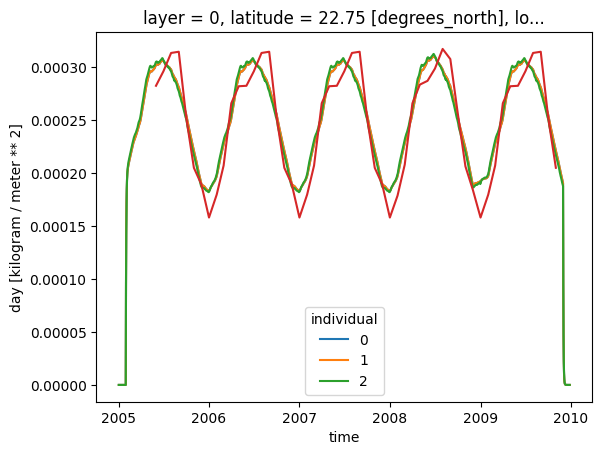

In [28]:
best_simulations.squeeze().plot.line(x="time")
observations[0].observation.squeeze().plot.line(label="Day observation")